# Arbitraje Pricing Theory (APT). Modelo multifactorial

## Las limitaciones del CAPM

Si revisamos las hipótesis de partida del CAPM e indentficamos sus desviaciones podremos apreciar la existencia de nuevos factores de riesgo distintos del riesgo de mercado.

1. Los inversores tienen sólo riqueza financiera.
    
    Los inversores no sólo tienen ingresos derivados de sus inversiones financieras y de su actividad profesional sino que además tienen deuda. Si bien los primeros son inciertos, los segundos son fijos. Los ingresos suelen reducirse en etapas de crisis económica y el coste de la deuda incrementarse en con un aumento de la inflación. Por eso dos factores de riesgo tienen que ser el crecimiento económico y la inflación.

    **Leer Jagannathan and Wang (1996) found large improvements in the performance of the CAPM when labor income risk is taken into account**

2. La utilidad de los inversores está basada en el binomio rentabilidad-riesgo
    
    El riesgo suele ser asimétrico ya que el inversor suelen estar más angustiados por las pérdidas que satisfechos por las ganancias, esto genera desviaciones con respecto a las previsiones del CAPM.

- Cuando tratamos con acciones individuales hemos contrastado:
    
    - Existe una prima por riesgo por mayor curtosis tienen una prima de por riesgo (Ang, Chen, and Xing 2006)
    
    - Existe una prima por riesgo asociado a los momentos. Es decir, los precios tienen memoria. 
    
    - Existe una prima de riesgo asociada a la asimetria (Mitton and Vorkink 2007, Boyer, Mitton, and Vorkink 2010, and Amaya et al. 2012). 

- Cuando tratamos con carteras se ha verficado que existe una prima de riesgo derivada de cómo los rendimientos de las acciones covarian con momentos superiores del mercado.
    
    - Existe una prima por riesgo por co-skewness y co-kurtosis, que resultan del co-movimiento de los rendimientos de las acciones con los momentos de skewness y kurtosis de la cartera de mercado (Harvey and Siddique 2000, Dittmar 2002, Chang, Christoffersen, and Jacobs 2013. 

3. Horizonte temporal de una periodo

    Aunque un horizonte temporal de largo plazo es un supuesto intrascendente para la teoría del CAPM. Debemos tener presentes que si analizamos las carteras en un horizonte temporal dinámico el rebalanceo de carteras esta la estrategia óptima.

4. Los inversores tienen expectativas homogéneas.
    
    Todos los inversores tienen la misma cartera de mercado M. Pero en la realidad cada inversor tiene sus propios segos que generan expectativas heterogéneas lo que puede generar importantes desviaciones con respecto al CAPM. Las creencuas de los inversores pueden ser otro factor de riesgo.
    
5. No existe ni impuestos ni costes de transacción
    
    - No todos los activos tienen una fiscalidd equivalente por tanto debe considerarse que los impuestos son un factor sistemático.
    
    - Los costes de transacción no son homogeneos entre todos los activos, podemos suponer que son mayores para los que presentan menores niveles de liquidez, por ello puede existir un premio por la liquidez.

6. Los inversores son precio aceptantes

    Lamentablemente existen inversores con mejor acceso a la información, si esto tienen acceso a una fuerte cantidad de capital puedne generar desviaciones con respecto al CAPM.

7. La información no tiene costes y esta disponible para todos los inversores.

    Ni la información no tiene coste, ni todas las empresas tienen el mismo nivel de transparencia, por tanto el acceso a la información puede ser considerado un nuevo factor de riesgo (Veldkamp 2011).

# Un modelo multifactorial como alternativa

Una interpretación del CAPM puede ser la rentabilidad exigida a los activos en función del comportamiento de los mismos en los tiempos de crisis. La pregunta que nos planteamos es porque medimos los tiempos de crisis con una única variable: la evolución del mercado. El modelo multifactorial propone definir los tiempos de crisis con más de una variable o factor. Dicho modelo es el _arbitraje pricing theory_ (APT) desarrollado por Ross (1976). En equilibrio los inversores exigen rentabilidad por los distintos factores de riesgo. Por tanto, el CAPM es un caso particular del APT.

Si consideramos únicamente el riesgo de mercado, estamos hablando de estimar el CAPM:
$$E(r_i)=r_f+\beta E(r_m)$$

Un modelo multifactorial con $k$ factores tendría la siguiente expresión:

$$E(r_i)=r_f+\beta_{i,1}E(f_i)+\beta_{i,2}E(f_i)+...+\beta_{K,1}E(f_K)$$

donde $\beta_{i,k}$ es la beta del activo $i$ con respecto al factor $k$, $E(f_k)$ es el factor de riesgo $k$. Estos factores pueden ser macro, como la inflación, el crecimiento económico, el tipo de cambio...

Una ventaja de este enfoque es que los factores pueden, a veces, tener una interpretación económica. La desventaja es que no existe un consenso sobre la identidad de los factores,excepto para el  índice de mercado. Tampoco lo hay sobre el número de factores K (Connor y Korajczyk, 1995). En otras palabras, la elección entre modelos de factores es muy ad hoc. No significa que ninguno de ellos funcione bien, significa que no sabemos cuál funciona bien a priori. Por ejemplo, si estamos interesados en seleccionar carteras con baja varianza fuera de la muestra, en cualquier conjunto de datos dado puede existir un modelo factorial que funcione bien, pero puede ser uno diferente para cada conjunto de datos, y no hay forma de saber cuál funciona bien. El arte de elegir un modelo factorial adaptado a un conjunto de datos determinado sin ver su ajuste fuera de la muestra es sólo eso: un arte.

Disponemos dos tipos de factores los macro y los dinámicos. La diferencia entre ambos radica en que dinámicos pueden adquirirse y los macro no. Veamos cuales han sido los más estudiados.

## Expresión Matricial del Modelo Multifactorial

Podemos expresar matricialmente el modelo factorial, en que el rendimiento aleatorio de cada activo es una combinación lineal de un pequeño número de factores comunes, más una variable aleatoria específica del activo:
- $n$ es el número de activos
- $k$ es el número de factores
- $f$ es el vector de $k$ de factores aleatorios
- $B$ es la matriz $n \times k$ de coeficientes lineales $(\beta_i)$ que representan la sensibilidad de los activos a los movimientos de los factores (denominados betas factoriales o cargas factoriales)
- $\varepsilon$ el vector de $n$ de variables aleatorias específicas de los activos $(\varepsilon_i)$  (denominadas rendimientos idiosincrásicos). 

Matricialmente el vector de rentabilidad de los activos $r$ como los rendimientos esperados más la suma de dos fuentes de rendimiento aleatorio, el rendimiento de los factores y el rendimiento idiosincrático:
$$r=E[r]+Bf+\varepsilon$$

donde $E[f]=0$, $E[\varepsilon]=0$ y $E[f\varepsilon']=0$. La matriz beta será por tanto $B=E[(r-E(r))f'](E[ff'])^{-1}$

Dado que los factores y el riesgo idiosincrático tienen que estar incorrelacionados la matriz de varianza y covarianza de los activos será $\Sigma=E[(r-E(r))(r-E(r))']$ puede ser escrita como la suma de dos matrices, la matriz de covarianzas de los factores y la matriz de covarianzas del riesgo idiosincrático:
$$\Sigma=BE[ff']+V$$

donde $V=E[\varepsilon\varepsilon']$ por definición los riesgo idisincráticos están incorrelacionados entre ellos, por tanto  $V$ es una matriz diagonal.

Un modelo **factorial estricto** divide el vector de las rentabilidades en un proceso aleatorio provocado por $k$ factores comunes de riesgo y $n$ factores específicos de riesgo. Para un número elevado de activos la varianza idiosincrática de una cartera equiponderada $w$ será:

$$w'Vw=\sum_{i=1}{n}w^2_i\sigma_i^2\sum_{i=1}{n}\leq(\max_{i}\sigma_i^2)\sum_{i=1}^2 w_i^2$$ 

Dado que $w=\frac{1}{n}$ ante una número elevado de activos el riesgo idiosincrático tenderá a cero. Por tanto, el modelo factorial estricto propone que una cartera adecuadamente diversificada únicamente asume riesgo sitemático.

Por tanto proponemos que retorno esperado de un activo es una función lineal de varios factores macroeconómicos o factores de mercado, y cada uno de estos factores tiene asociado un beta que mide la sensibilidad del retorno del activo a ese factor.  

## Factores implícitos

El reto radica en la identificación de los factores. Una primer alternativa consiste en utilizar descomponer la matriz de covarianza de los retornos de los activos en autovectores y autovalores mediante el análisis de componentes principales (PCA, por sus siglas en inglés) o técnicas similares. 

Recordemos que el análisis por componentes principales permite la siguiente descomposición de la covarianza o la matriz de correlaciones:
$$C=VDV'$$

donde C es la matriz de correlaciones de las rentabilidad históricas, D es la matriz diagonoal de los autovalores y V es la matriz de los autovectores. La utilización de la matriz de correlaciones permite normalizar los activos en función de su volatilidad, con ello evitamos que los activos más volátiles determinen los autovectores.
 

Si ordenamos los elementos diagonales de la matriz D en orden descendente, sabemos que el valor propio superior, $\lambda_1$, explica la mayor parte de la varianza, seguido de $\lambda_2$, y así sucesivamente. Además, sabemos que los valores propios $\lambda_i$ nos indican con precisión cuánta varianza explica cada componente principal .

Dichos autovectores o factores implícitos son combinaciones lineales de los factores de riesgo originales y pueden revelar relaciones subyacentes no obvias entre los activos y los factores de riesgo. Además, dichos factores son ortogonales evitando los problemas de multicolinealidad.

Esta solución plantea dos problemas:
- Seleccionamos un número determinado de factores implícito renunciando a parte de la información. 
- En muchos casos los factores no se pueden interpretar desde una perspectiva económica.


## Factores Macro

Una alternativa es buscar la explicabilidad de los modelos, es decir, identificar los factores macroecnómicos que mejor predicen las rentabilidad es futuras. En este apartado revisaremos los principales factores identificados por la evidencia disponible:
- El crecimiento económico
- La inflación
- La volatilidad


### Crecimiento económico.

La evidencia nos ha permitido verificar que las acciones pierden valor y incrementan su volatilidad cuando estamos en una etapa de bajo crecimiento económico. En este contexto, la política monetaria será expansiva y por tanto tenderá a bajar los tipos de interés lo que en cierta medida puede tener un impacto positivo en los precios de las acciones contrarestando parcialmente el efecto inicial. Lógicamente, en un entorno de crecimiento económico los precios tenderán a subir, aunque pueden verse frenados por una posible política monetaria más restrictiva. En la Tabla 4.1., se han determinado la rentabilidad media y la volatilidad de las acciones de las grandes empresas y de las pequeñas, en entornos de crecimiento económico y de recesión, confirmándose lo planteado. 

**Tabla 4.1: Efecto del crecimiento económico** 

![growth](../imgs/crecimiento_eco.png)

 Ang (2014)

### La inflación

Un incremento en las expectativas de inflación tiene un efecto directo y positivo en las rentabilidades exigidas a los activos tanto de renta fija como de renta variable, además genera incertidumbre sobre el comportamiento de las economías al producirse una reducción del poder de compra real, lo que puede tener un impacto en el consumo, o un incremento de los costes de producción que reduzca la competitividad de las empresas. Por tanto una inflación alta reduce el rendimiento tanto de las acciones como de los bonos.

### La volatilidad

La volatilidad se suele medir utilizando el indice VIX, que es una medida de la volatilidad de las opciones sobre el S&P 500 elaborada por el Chicago Board Options Exchange. 

La incertidumbre política y económica genera volatilidad. Un incremento de la misma lleva asociado un aumento de la rentabilida exigida, perjudicando al precio de las acciones. En este contexto, los bonos se convierten en un activo refugio, por ello, la elevada volatilidad perjudica a las acciones y beneficia a los bonos. Así se puede apreciar que el incremento de volatilidad tiene un impacto negativo en el rendmimiento de las acciones y un impacto positivo sobre el valor de los bonos pero de menor intensidad.

**Tabla 4.2: Correlaciones entre marzo 1986 y diciembre de 2011**

![VIX](../imgs/VIX.jpg)

Tema_5_APT/imgs/VIX..jpg

Ang (2014) 

Los momentos de alta volatilidad están provocados por noticias inesperadas crash 1987 anterior a la recesión de los noventa, la crisis de la deuda de Rusia en 1998, la caida de las torres gemelas de 2001 y la caidaa de Lehman Brothers 2008. Estos acontecimientos provocaron fuertes caídas en precios.

**Figura 4.1:Evoloción del VIX y del SP&500** 

![VIX_2](../imgs/VIX_2.jpg)

Ang (2014) 


### Otros factores
Del mismo modo exponemos otros factores menos habituales como la productividad, la demografía y la política.

#### Productividad

Los shocks de productividad tienen un importante efecto en las empresas. Los trabajos de Jermann (1988) y Kaltenbrunner y Lochstoer (2010) reflejan una dinámica realista y compleja de las perturbaciones y el comportamiento de los agentes, antes shocks de productividad e incluyen el comportamiento de los mercados financieros.

Este tipo de factores son relevantes para los inversores de largo plazo, ya que su impacto no es inmediato. En la Tabla 4.3 se representa la evolución de los schoks de productividad, estimada a partir del factor total de productividad (TFP). En ella se puede apreciar que cuando se produce una caída continuada de productividad los precios tienden a caer, y recuperarse cuando asistimos a un incremento de la productividad.


**Tabla 4.3: media quinquenal de los choques de productividad y los rendimientos bursátiles**

![Productividad](../imgs/productividad.jpg)

Ang (2014) 

### Demografía

El riesgo demográfico, nos interesa las perturbaciones que puede tener la evolución demográfica en el mercado de trabajo. Es una variable de evolución lenta y su impacto es de largo plazo (Erb, Harvey, and Viskanta (1997),
Ang and Maddaloni (2005), and Arnott and Chaves (2011).

### Riesgo político

El riesgo político siempre ha sido importante en los mercados emergentes: cuanto mayor es el riesgo político, mayores son las primas de riesgo necesarias para compensar a los inversores por asumirlo. Se pensaba que el riesgo político sólo preocupaba en los mercados emergentes. La crisis financiera cambió esta situación, y en el futuro el riesgo político también será importante en los países desarrollados (Pástor and Veronesi 2012).


Chen, Roll, and Ross (1986).

## Factores dinámicos


### Modelo de Fama y French

La principal referencia en este ámbito es Fama y French (1993) que parte del CAPM y añade dos factores adicionales para capturar el efecto tamaño y el efecto valor/crecimiento:

$$E(r_i)=r_f+\beta_{i,MKT} E(r_m-r_f)+\beta_{i,SMB} E(SMB)+\beta_{i,HML} E(HML)$$

- $r_m$ es la rentabilidad del mercado
- $SMB$ al rendimiento diferencial de los valores pequeños frente a los grandes (de ahí SMB), donde pequeño y grande se refieren simplemente a la capitalización bursátil de los valores. Se diseño para capturar la diferencia de rentabilidad entre las empresas grandes y pequeñas. Fama y French (1993) proponen la siguiente metodología para construir el factor $SMB$:
    1. Ordenamiento de las empresas por su capitalización de mercado

    2. Creación de dos carteras según el tamaño. Para ello, dividen las acciones en dos grupos: pequeñas y grandes. El criterio utiliza es la mediana de la capitalización de mercado. Las empresas con una capitalización de mercado inferior a la mediana se clasifican como pequeñas, mientras que las que tienen una capitalización superior a la mediana se clasifican como grandes.
    
    3. Cálculo de  las rentabilidades promedio. Se calculan la rentabilidad media de ambas carteras considerando las acciones que los componen. La ponderación de cada uno de los activos se estima en función de su tamaño. Por tanto la rentabilidad media será un media ponderada en funciónd del tamaño de la rentabilida rentabilidad histórica de las acciones durante un periodo específico.
    
    4. Construcción del factor SMB como la diferencia entre la rentabilidad promedio de las acciones pequeñas y la rentabilidad promedio de las acciones grandes. 

- $HML$ que representa la rentabilidad de una cartera de valores con una alta relación entre el valor contable y el valor de mercado menos una cartera de valores con una baja relación entre el valor contable y el valor de mercado. Las empresas con potencial de crecimiento tienen normalmente un alto valor del _price-to-book_. Generalmente las empresas value baten a las empreas de crecimiento. La metodología propuesta es la siguiente:

    1. Clasificación de acciones Basada en la relación _price-to-book_. Esta relación se calcula dividiendo el precio de mercado de una acción por su valor en libros (o valor contable). Las acciones se ordenan de menor a mayor según su _price-to-book_ y se dividen en tres tercios: tercio inferior (alto valor en libros), tercio medio, y tercio superior (bajo valor en libros).

    2. Formación de las carteras de **Valor y Crecimiento**. Las acciones en el tercio inferior (alto valor en libros) forman los portafolios de "valor" (High Book-to-Market), mientras que las del tercio superior (bajo valor en libros) forman los portafolios de "crecimiento" (Low Book-to-Market).

    3. Cálculo de rentabilidades Promedio. Se calcula la rentabilidad promedio para cada uno de estos portafolios (valor y crecimiento) durante el período de estudio. Los activos están ponderados en función de su _price-to-book_.

    4. Construcción del factor $HML$. El factor HML se construye como la diferencia entre la rentabilidad promedio de los portafolios de valor y la rentabilidad promedio de los portafolios de crecimiento. Es decir, $HML = Rentabilidad Promedio Valor - Rentabilidad Promedio Crecimiento$.

Un supuesto importante de los modelos CAPM y Fama-French es que las betas son constantes. Sin embargo, la evidencia empírica confirma que la exposición a los factores varia a lo largo del tiempo e incrementa significativamente en los tiempos de crisis, lo que generá rendimiento negativos pues reduce el valor de los activos.

### El factor tamaño

Los trabajos de Banz (1981) y Reinganum(1982) evidenciaron que los valores pequeños tendían a hacerlo mejor que los grandes, una vez ajustadas sus betas. Sin embargo, se puede apreciar en la Tabla 3.4. que desde mediados de la década de 1980 no ha habido ningún efecto significativo del tamaño (Dimson, Marsh, and Staunton, 2011;Fama and French, 2012). Dos razones explicarían la desaparición del efecto tamaño:
- Posiblemente el premio de tamaño identificado podría haber sido simplemente minería de datos.Un efecto parece significativo en la muestra, donde los modelos se estiman originalmente, pero falla fuera de la muestra, donde los modelos se prueban después de su descubrimiento.
- El efecto del tamaño realmente existía. Al conocerse el hallazgo las decisiones de los inversores racionales provocarón un incremento del precio de los valores de pequeña capitalización y el efecto desapareció.

**Tabla 3.4: Rentabilidad de mercado ajustada a las estrategias SMB y HML**

![Tamaño](../imgs/Tamaño.jpg)

Fuente: Ang and Chen (2002)

El débil efecto del tamaño en la actualidad significa que un propietario de activos no debería inclinarse por los valores pequeños únicamente para obtener mayores rendimientos ajustados al riesgo.

### El factor valor

 En función del potencial de crecimiento, podemos clasificar las empresas en dos grandes grupos: 
 - Las empresa de crecimiento: dado que en este caso compramos los flujos de caja futuros su valor de mercado es superior a su valor contable. 
 - Las empresas valor: son organizaciones maduras con una cuota de mercado estable en el tiempo y elevado capital reputacional. En este caso, las acciones tienen precios bajos en relación con su valor contable. 
 
Históricamente, las acciones de valor se imponen a las de crecimiento. Por tanto el potencial de crecimiento puede ser un factor de riesgo a tener en cuenta. En la Figura 3.4. se puede observar que el factor valor ha generado un exceso de rentabilidad ajustada por el riesgo mercado. Sin embargo, esto no es gratis, ya que generaron importantes pérdidas durante la crisis de la puntocom de principio de los noventa y en la crisis de 2007-2008. Si bien las empresas valor generan una mayor rentabilidad en el largo plazo son más vulnerables en las etapas de crisis. Ello se explica por la menor flexibilidad de las empresas valor, es decir, se enfrentan a unos coste de ajustes elevados. Las empresas en crecimiento son mucho más flexibibles, sólo se debe tener en cuenta los menores costes de despido por la juventud de la plantilla.

Desde una perspectiva racional se propone que el valor no puede diversificarse y por ello se debe exigir una prima de rentabilidad.

Desde las perspectiva de las finanzas conductivista, se porpone que las empresas valor no son más arriesgadas que las empresas crecimiento. Está aproximación teórica considera que los inversores se enfrentan a sesgos cognitivos que les llevan a sobrereaccionar a la información. Así, se sobrevalora el potencial de crecimiento de las empresas crecimiento y se infravalora en las empresas de valor. Por ello las empresas de crecimiento son caras y las de valor baratas. Además dos sesgos cognitivos adicionales nos permite explicar la diferencia de comportamiento: 
- la aversión a las pérdidas: los inversores sufren más por las pérdidas que por los beneficios equivalentes
- la contabilidad mental: los inversores analizan las empresas individualmente sin considerar lo que aporta a su cartera. 

Eso lleva a pensar que cuando una empras tiene un _price-to-book_ bajo se explique por los malos resultados obtenidos en el pasado y se le exija por ello una prima por riesgo.

### El factor momento

El trabajo de Jegadeesh and Titman (1993) propone el factor momento. Dicha estrategia consiste en comprar valores que han subido en los últimos seis meses (ganadores) y vender en corto los valores con menor rentabilidad en el mismo periodo (perdedores). La hipótesis subyascente es que los valores ganadores siguen ganando y los perdedores siguen perdiendo. 

A menudo el momento se incluye en el modelode de Fama y French:

$$E(r_i)=r_f+\beta_{i,MKT} E(r_m-r_f)+\beta_{i,SMB} E(SMB)+\beta_{i,HML} E(HML)+\beta_{i,WML} E(WML)$$

Llamamos al factor de momento WML, para ganadores pasados menos perdedores pasados. (También se denomina UMD, para las acciones que han subido menos las que han bajado). Para clasificar un activo en la cartera de ganadores o perdedores en la estrategia de inversión basada en el factor WML (Winners Minus Losers), el indicador más comúnmente utilizado es el rendimiento total pasado del activo. Veamos cómo se hace esta clasificación:

1. Selección de un periodo de formación para analizar el rendimiento pasado de los activos. Este periodo puede variar, pero suele ser de 3 a 12 meses. Durante este tiempo, se mide el rendimiento total de cada activo.

2. Cálculo del rendimiento total que incluye tanto la apreciación (o depreciación) así como el reparto de dividendos. 

3. Clasificación de los activos función de su rendimiento total:
   - Los activos con los rendimientos más altos se clasifican como "ganadores".
   - Los activos con los rendimientos más bajos se clasifican como "perdedores".

    Los criterios comúnmente utilizados para discriminar los activos "ganadores" de lo perdedores son:

    2. Clasificar a los activos como ganadores si están en un **percentil** superior específico (por ejemplo, el 10%, 20% o 30% superior). Utilizar el simétrico para los perdedores.
    3. Seleccionar como activos gansdores aquellos cuyo rendimiento total supera el **rendimiento promedio o la mediana** de todos los activos en el universo de inversión durante el periodo de formació
    4. Establecer un **umbral de rendimiento absoluto** y seleccionar como activos ganadores aquellos que lo superen. Por ejemplo, elegir activos que hayan obtenido un rendimiento superior al 5% en el periodo. Lógicamente se definiría otro umbral para identificar los perdedores
    5. Seleccionar activos que hayan superado un **índice de referencia o benchmark** específico durante el periodo de formación.
    6. Además del rendimiento, utilizar indicadores técnicos como el promedio móvil, RSI (Relative Strength Index) o MACD (Moving Average Convergence Divergence) para identificar activos en tendencia alcista uy bajista.
    7. Seleccionar activos no solo por su rendimiento total, sino también por tener una relación favorable de rendimiento a volatilidad, indicando un **rendimiento ajustado por riesgo** más eficiente.
    8. Preferir activos que no solo han tenido un alto rendimiento en el periodo reciente, sino que también han mostrado un **rendimiento consistente** a lo largo de varios periodos anteriores.
    9. Algunas estrategias excluyen activos con rendimientos extremadamente altos que podrían ser resultado de eventos puntuales o volatilidad no sostenible.

4. Formación de Carteras de Ganadores y Perdedores:
   - Una cartera de "ganadores", que incluye los activos con mejor rendimiento.
   - Una cartera de "perdedores", que incluye los activos con peor rendimiento.

5. Tras la formación de las carteras, se establece un periodo de retención, durante el cual se mantiene la inversión en estas carteras. Este periodo puede ser también de varios meses.

6. Las carteras se rebalancean periódicamente para reflejar los cambios en los rendimientos de los activos y mantener la estrategia de momentum.

Es importante destacar que la selección del periodo de formación y de retención es crucial para el éxito de la estrategia. Además, otros factores como los costos de transacción, el impacto del mercado y el riesgo asociado deben ser considerados cuidadosamente. La estrategia de momentum no garantiza resultados positivos en todos los escenarios de mercado y puede tener periodos de bajo rendimiento, especialmente durante los giros de mercado o reversiones de tendencia.

**Tabla 3.R: Rentabilidad de mercado ajustada a las estrategias SMB y HML**

![Momento](../imgs/Momento.jpg)

Fuente: Ang and Chen (2002)

La respuesta más extendida sobre la explicación del factor momento proviene de las finanzas conductuales. El efecto del momento se debe a la forma sesgada en que los inversores interpretan o actúan ante la información. Supongamos que se conocen buenas noticias sobre un valor. En primer lugar, los inversores podrían tener una reacción exagerada y retardada a estas noticias provocando un subida presistente del precio. En segundo lugar, los inversores podrían no reaccionar a la noticia. El precio sube inicialmente, pero no tanto como debería para reflejar plenamente lo buena que era la noticia. Los inversores aprenden entonces y hacen que las acciones vuelvan a subir en el siguiente periodo. Existe una dilatada producción científica que trata de discirnir entre ambas aproximaciones.

La inversión en factores puede definirse como el enfoque de inversión que pretende monetizar la exposición a características de riesgo mensurables (denominadas "factores") que presumiblemente explican las diferencias en el rendimiento de un conjunto de valores. Sus orígenes se remontan a los trabajos seminales de Fama y MacBeth [1973] y Schipper y Thompson [1981], entre otros. Desde entonces, miles de trabajos académicos han reivindicado el descubrimiento de cientos de factores de inversión (Harvey et al. [2016]), impulsando el crecimiento de una industria multimillonaria. En 2019, J.P. Morgan estimó que más de 2,5 billones de USD (más del 20 % de la capitalización del mercado de renta variable estadounidense) estaban gestionados por fondos de estilo cuántico (Neuberger Berman [2019]). BlackRock estima que el sector de la inversión en factores gestionó 1,9 billones de USD en 2017, y proyectó que esa cantidad crecería hasta los 3,4 billones de USD en 2022 (BlackRock [2017]). 

# EJEMPLOS

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import cvxpy as cp
import plotly.graph_objects as go
from tqdm.auto import tqdm
import statsmodels.api as sm
import warnings
from datetime import datetime, timedelta
from joblib import Parallel, delayed
import requests
from bs4 import BeautifulSoup
from tqdm.auto import tqdm
import time
import csv
import pickle


# print(plt.style.available) #list of available styles
#plt.style.use('ggplot')
# Configura el estilo de Seaborn para que los gráficos se vean más atractivos
sns.set(style="whitegrid")

plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 100
warnings.simplefilter(action='ignore', category=FutureWarning)

## ANÁLISIS DE ACTIVOS MEDIANTE EL MODELO FAMA FRENCH DE TRES FACTORES

El modelo de Fama-French de tres factores amplía el modelo de valoración de activos de capital (CAPM) al incluir dos factores adicionales, tamaño y valor, para explicar mejor los rendimientos de las acciones.

Estos factores ayudan a explicar los rendimientos de las acciones más allá del CAPM, considerando el impacto del tamaño de la empresa y la propensión hacia acciones de valor o de crecimiento.

El modelo se utiliza para analizar y predecir el comportamiento de un activo de la siguiente manera:

- **Incluir el Mercado:** Evalúa cómo el activo reacciona ante los movimientos del mercado general, considerando la diferencia entre los rendimientos del mercado y la tasa libre de riesgo.

- **Considerar el Tamaño:** Analiza el impacto del tamaño de la empresa en el rendimiento del activo, comparando pequeñas empresas con grandes empresas.

- **Evaluar el Valor:** Examina la relación entre el valor de mercado de la empresa y su valor contable, diferenciando entre acciones de crecimiento y acciones de valor.

Utilizando estos tres factores, se puede obtener una comprensión más detallada de las fuerzas que influyen en el rendimiento de un activo, más allá de simplemente mirar el mercado en general. Esto ayuda a identificar si un activo está generando rendimientos por encima o por debajo de lo esperado dadas estas dimensiones de riesgo.


### Los **factores** que utiliza son::

1. **Mkt-RF (Mercado Menos Tasa Libre de Riesgo):** Mide el exceso de rendimiento del mercado sobre la tasa libre de riesgo.

   - Una **beta alta** indica que el activo es más sensible a los movimientos del mercado, mientras que una **beta baja** sugiere menor sensibilidad.

2. **SMB (Small Minus Big):** Representa la prima de riesgo asociada al tamaño de las empresas, comparando el rendimiento de empresas pequeñas con el de empresas grandes.

   - Una **beta positiva** indica una inclinación hacia empresas pequeñas (con mayor riesgo y potencial de rendimiento), y una **beta negativa** sugiere preferencia por empresas grandes y más estables.

3. **HML (High Minus Low):** Mide la diferencia de rendimiento entre empresas de alto valor (valor contable alto en relación con el precio de mercado) y empresas de crecimiento (precio de mercado alto en relación con el valor contable).

   - Una **beta positiva** implica una tendencia hacia empresas de valor, consideradas menos riesgosas pero con potencial de rendimientos consistentes, mientras que una **beta negativa** muestra una tendencia hacia empresas de crecimiento, que pueden ser más riesgosas pero con la posibilidad de altos rendimientos.

Interpretar las betas de estos factores ayuda a comprender cómo diferentes aspectos del mercado y características de la empresa afectan el rendimiento esperado de un activo, permitiendo a los inversores hacer decisiones más informadas basadas en el perfil de riesgo y retorno.


###  A continuación, se describe **cómo se calculan** estos tres factores de manera sencilla:

 1. **Exceso de Rendimiento del Mercado (Mkt-RF):**
Este factor mide la diferencia entre el rendimiento del mercado de acciones y la tasa libre de riesgo. Se calcula restando el rendimiento de un activo libre de riesgo, como los bonos del Tesoro de EE. UU., del rendimiento de un índice bursátil amplio, como el S&P 500.

 2. **Tamaño de la Empresa (SMB, Small Minus Big):**
El factor SMB mide la diferencia en rendimientos entre empresas pequeñas y grandes. Las acciones se dividen en dos grupos basados en su capitalización de mercado: pequeñas y grandes. Luego, se calcula el rendimiento promedio de las acciones pequeñas y se resta del rendimiento promedio de las acciones grandes.

 3. **Valor de la Empresa (HML, High Minus Low):**
El factor HML evalúa la diferencia en rendimientos entre empresas de "alto valor" (value stocks) y de "crecimiento" (growth stocks). Las acciones se clasifican en estas categorías según su relación price to book ratio. Se calcula el rendimiento promedio de las acciones de alto valor y se resta del rendimiento promedio de las acciones de crecimiento.

### Descarga de los Valores de los Factores

<p align="center">
  <img src="../imgs/fama-french-web.PNG" alt="Fama French Web" style="max-width:70%;">
</p>


Los valores de los factores de Fama-French pueden descargarse desde la **Base de Datos de Kenneth R. French**, alojada en la página web de la Tuck School of Business en Dartmouth College. Aquí se ofrecen datos históricos de los factores de riesgo para el mercado de valores de EE.UU. y otros países.

- **URL para la descarga:** [Base de Datos de Kenneth R. French](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html)

En esta página, puedes encontrar los factores para diferentes periodos y frecuencias temporales, incluyendo datos diarios, mensuales y anuales.

## Análisis de una acción

Pasos a seguir:

1- Bajarnos los precios de cierre ajustados mensuales de la acción y calcular los retornos

2- Bajarnos los factores del modelo de Fama French también mensuales

3- Hacer la regresión lineal según el modelo de fama french: $\quad (R_{activo} - R_f) = \alpha + \beta_1 (Mkt-R_f) + \beta_2 SMB + \beta_3 HML$

4- Analizar los resultados

**1- Nos bajamos los precios y calculamos los retornos.**

Bajamos los precios mensuales ya que os retornos diarios contienen mucho ruido

In [36]:
precios_accion = pd.read_csv('../data/accion.csv', index_col='Date', parse_dates=True)

returns_accion = np.log(precios_accion).diff().dropna()

returns_accion.head(2)

,Adj Close
Date,
2015-02-01,0.081945
2015-03-01,-0.068439


**2- Nos bajamos los factores de un fichero ya descargado y limpio**

In [37]:
filepath ='https://raw.githubusercontent.com/alfonso-santos/microcredencial-carteras-python-2023/main/Tema_5_APT/data/F-F_Research_Data_Factors_monthly.csv'
ff_factors = pd.read_csv(filepath , index_col=0, parse_dates=True)

ff_factors

,Mkt-RF,SMB,HML,RF
1926-07-01,2.96,-2.56,-2.43,0.22
1926-08-01,2.64,-1.17,3.82,0.25
1926-09-01,0.36,-1.40,0.13,0.23
1926-10-01,-3.24,-0.09,0.70,0.32
1926-11-01,2.53,-0.10,-0.51,0.31
...,...,...,...,...
2023-07-01,3.21,2.08,4.11,0.45
2023-08-01,-2.39,-3.16,-1.06,0.45
2023-09-01,-5.24,-2.51,1.52,0.43
2023-10-01,-3.19,-3.87,0.19,0.47


In [38]:
# Dividimos los factores por 100 para poder comparar con los retornos de las acciones
ff_factors = ff_factors / 100
ff_factors

,Mkt-RF,SMB,HML,RF
1926-07-01,0.0296,-0.0256,-0.0243,0.0022
1926-08-01,0.0264,-0.0117,0.0382,0.0025
1926-09-01,0.0036,-0.0140,0.0013,0.0023
1926-10-01,-0.0324,-0.0009,0.0070,0.0032
1926-11-01,0.0253,-0.0010,-0.0051,0.0031
...,...,...,...,...
2023-07-01,0.0321,0.0208,0.0411,0.0045
2023-08-01,-0.0239,-0.0316,-0.0106,0.0045
2023-09-01,-0.0524,-0.0251,0.0152,0.0043
2023-10-01,-0.0319,-0.0387,0.0019,0.0047


In [39]:
precios_factors = np.exp(ff_factors.cumsum())

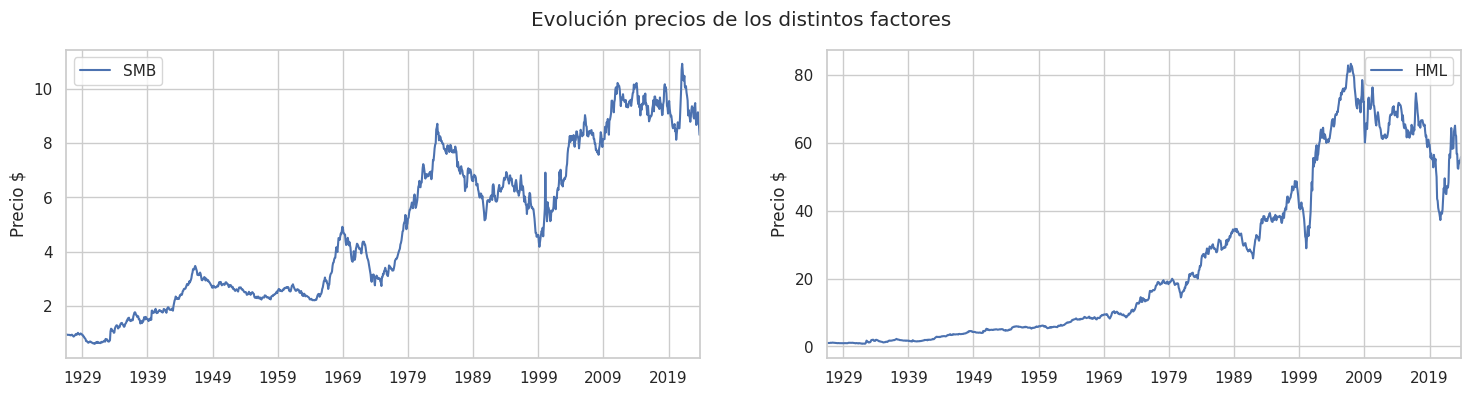

In [40]:
# Create a figure and a set of subplots with specific size
from operator import le
from matplotlib import legend


fig, ax = plt.subplots(1, 2, figsize=(18, 4))

# Plot the selected columns from your DataFrame on the first subplot
precios_factors.loc[:,'SMB'].plot(ax=ax[0], legend=True, label='SMB')
ax[0].set_ylabel('Precio $')

# Plot the last two columns from your DataFrame on the second subplot
precios_factors.loc[:, 'HML'].plot(ax=ax[1], legend=True, label='HML')
ax[1].set_ylabel('Precio $')

# You can set a general title for the figure with fig.suptitle
fig.suptitle('Evolución precios de los distintos factores')


plt.show();

In [41]:
sp500 = yf.download('^GSPC', start=precios_factors.index[0], end=precios_factors.index[-1], interval='1mo')['Adj Close']

[*********************100%%**********************]  1 of 1 completed


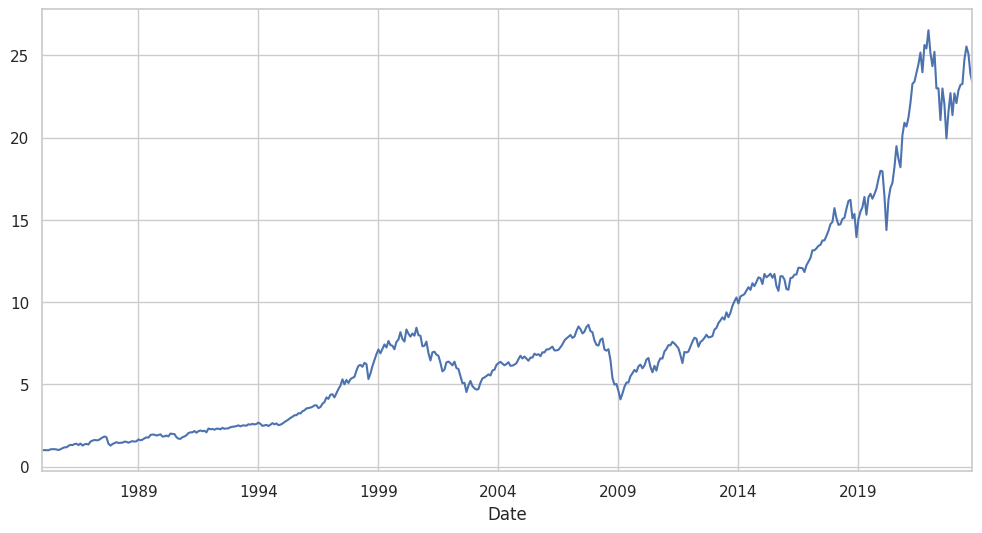

In [42]:
# Veamos la evolución de los precios del S&P 500
(sp500/sp500[0]).plot(figsize=(12,6))
plt.show()


Las empresas de gran capitalización suelen tener un comportamiento más estable tanto en mercados alcistas como bajistas. En mercados alcistas, pueden no crecer tan rápidamente como empresas de menor capitalización debido a su ya establecida escala y estabilidad. En mercados bajistas, son preferidas por su seguridad, estabilidad financiera y capacidad para pagar dividendos, lo que puede hacer que se desempeñen mejor o pierdan menos valor en comparación con empresas más pequeñas y volátiles.

La **beta** de una acción indica su volatilidad en relación con el mercado:

- **Beta mayor que 1:** La acción es más volátil que el mercado. Tiende a amplificar los movimientos del mercado, subiendo más en mercados alcistas y bajando más en mercados bajistas.
- **Beta menor que 1:** La acción es menos volátil que el mercado. Tiende a tener movimientos más suaves, subiendo menos en mercados alcistas y bajando menos en mercados bajistas.


In [43]:
# Creamos el dataframe con os factores y los retornos de la acción

datos_df = pd.concat([ff_factors, returns_accion], axis=1, join='inner')
datos_df.columns = list(ff_factors.columns) + ['Accion']
datos_df.head(5)

,Mkt-RF,SMB,HML,RF,Accion
2015-02-01,0.0613,0.0063,-0.0186,0.0,0.081945
2015-03-01,-0.0112,0.0304,-0.0037,0.0,-0.068439
2015-04-01,0.0059,-0.0306,0.0182,0.0,0.179201
2015-05-01,0.0136,0.0093,-0.0114,0.0,-0.037282
2015-06-01,-0.0153,0.0291,-0.0079,0.0,-0.053093


**3- Realizamos la regresión lineal**

In [44]:
Y = datos_df.loc[:, 'Accion']-datos_df['RF']
X = datos_df[['Mkt-RF', 'SMB', 'HML']]

X = sm.add_constant(X)

modelo = sm.OLS(Y, X).fit()

print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     58.54
Date:                Mon, 08 Apr 2024   Prob (F-statistic):           4.32e-22
Time:                        17:31:25   Log-Likelihood:                 199.24
No. Observations:                 106   AIC:                            -390.5
Df Residuals:                     102   BIC:                            -379.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0108      0.004      2.870      0.0

**4- Analizar los resultados**

La interpretación de los resultados para la acción en el modelo de tres factores de Fama-French, incluyendo el valor de R-cuadrado, se presenta de manera concisa:

##### **R-cuadrado: 0.623**
El **R-cuadrado** de **0.623** indica que aproximadamente el **62.3%** de la variabilidad en los retornos se explica por los tres factores del modelo de Fama-French. 

##### **Alpha (constante): 0.0108**
La acción ha generado, en promedio, un **rendimiento mensual del 1,08%** por encima de la tasa libre de riesgo, ajustado por los factores de riesgo del modelo. Este exceso de retorno es **estadísticamente significativo** (P = 0.004), indicando un rendimiento superior debido a una buena gestión de la empresa.

##### **Mkt-RF: 1.0061**
La **sensibilidad de la acción al mercado** es ligeramente superior a 1, indicando que sus acciones tienden a moverse en línea con el mercado pero con una volatilidad ligeramente mayor. Este efecto es **altamente significativo** (P = 0.000).

##### **SMB: -0.6730**
Muestra una **beta negativa para SMB**, reflejando su estatus como una gran corporación y su tendencia a rendir de manera opuesta a las pequeñas empresas. La **significancia estadística** (P = 0.000) confirma la relevancia de este factor.

##### **HML: -0.4315**
Una **beta negativa para HML** sugiere que actúa más como una acción de crecimiento que de valor. Este efecto también es **estadísticamente significativo** (P = 0.000).

En resumen, el análisis muestra que **la acción ha superado el rendimiento esperado** basado en los riesgos del mercado y factores específicos, con su rendimiento en gran medida explicado por el modelo de Fama-French.


---

### Análisis por tipo de industria


La web de Fama-French proporciona factores de riesgo desglosados por industria, lo cual es esencial para analizar las acciones según su sector.

Al ofrecer estos datos, permite realizar regresiones lineales de los retornos de una acción contra los factores específicos de su industria.

Este análisis ayuda a determinar la afinidad de la acción con su sector, basándose en cómo sus retornos se relacionan con los factores industriales, facilitando así decisiones de inversión más precisas.

**Nos bajamos los factores por industria** En este caso usamos el modelo con 5 factores.

In [47]:
# Definir una función para analizar las fechas en el formato específico
dateparse = lambda x: pd.to_datetime(x, format='%Y%m')

filepath = 'https://raw.githubusercontent.com/alfonso-santos/microcredencial-carteras-python-2023/main/Tema_5_APT/data/5_Industry_Portfolios.CSV'

# Leer el archivo CSV con el analizador de fechas personalizado
industries_ff_df = pd.read_csv(filepath, index_col=0, parse_dates=True, date_parser=dateparse)

In [48]:
# Convertimos los retornos en tento por uno

industries_ff_df = industries_ff_df / 100
industries_ff_df

,Cnsmr,Manuf,HiTec,Hlth,Other
1926-07-01,0.0543,0.0273,0.0183,0.0177,0.0213
1926-08-01,0.0276,0.0233,0.0241,0.0425,0.0435
1926-09-01,0.0216,-0.0044,0.0106,0.0069,0.0029
1926-10-01,-0.0390,-0.0242,-0.0226,-0.0057,-0.0284
1926-11-01,0.0370,0.0250,0.0307,0.0542,0.0211
...,...,...,...,...,...
2023-08-01,-0.0182,-0.0182,-0.0158,-0.0022,-0.0335
2023-09-01,-0.0494,-0.0395,-0.0582,-0.0471,-0.0341
2023-10-01,-0.0343,-0.0305,-0.0168,-0.0458,-0.0253
2023-11-01,0.0788,0.0522,0.1165,0.0587,0.1041


In [49]:
#Generamos un df con los factores y los retornos de Microsoft

datos_ind_df = pd.concat([industries_ff_df, returns_accion], axis=1, join='inner')
datos_ind_df.columns = list(industries_ff_df.columns) + ['Accion']
datos_ind_df = pd.concat([datos_ind_df,ff_factors['RF']], axis=1, join='inner')
datos_ind_df.head(5)

,Cnsmr,Manuf,HiTec,Hlth,Other,Accion,RF
2015-02-01,0.0562,0.0370,0.0839,0.0424,0.0721,0.081945,0.0
2015-03-01,-0.0050,-0.0188,-0.0239,0.0076,-0.0059,-0.068439,0.0
2015-04-01,-0.0105,0.0166,0.0190,-0.0142,0.0062,0.179201,0.0
2015-05-01,0.0114,-0.0122,0.0164,0.0491,0.0174,-0.037282,0.0
2015-06-01,-0.0092,-0.0310,-0.0293,0.0016,0.0003,-0.053093,0.0


**Hacemos la regresión lineal**

In [50]:
Y = datos_ind_df.loc[:, 'Accion']-datos_ind_df['RF']
X = datos_ind_df[['Cnsmr', 'Manuf', 'HiTec', 'Hlth ', 'Other']]

X = sm.add_constant(X)

modelo = sm.OLS(Y, X).fit()

print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     42.18
Date:                Mon, 08 Apr 2024   Prob (F-statistic):           3.64e-23
Time:                        17:38:20   Log-Likelihood:                 206.29
No. Observations:                 106   AIC:                            -400.6
Df Residuals:                     100   BIC:                            -384.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0073      0.004      2.017      0.0

Podemos observar que el único factor que es significativo $P<0.05$ es el factor de HiTech y que además:

-  tiene un $\alpha$ positivo y significativo
-  tiene un $\beta > 1$ 

---

## Análisis de un fondo de inversión

Un fondo de inversión es un vehículo financiero que reúne capital de varios inversores para invertir colectivamente en una diversa cartera de activos, como acciones, bonos, o instrumentos del mercado monetario, gestionado por profesionales.

Las características específicas de cómo y en qué invierte el fondo, incluyendo su estrategia de inversión, objetivos, riesgo, y perfil de retorno, se definen detalladamente en su folleto. Este documento es esencial para que los inversores entiendan la naturaleza del fondo, sus metas y cómo busca alcanzarlas, proporcionando la transparencia necesaria para tomar decisiones informadas de inversión.

Las características de los fondos de inversión se pueden explorar detalladamente en la web de Morningstar https://www.morningstar.com/funds , una plataforma reconocida por ofrecer análisis y datos financieros.

En Morningstar, se destaca el uso del "Style Box", una herramienta visual que clasifica los fondos de inversión según su tamaño (capitalización de mercado) y estilo (valor, mezcla, crecimiento), proporcionando una comprensión rápida de la naturaleza de la inversión del fondo.

<p align="center">
  <img src="../imgs/descripcion fondo.PNG" alt="Fama French Web" style="max-width:70%;">
</p>



Además, Morningstar ofrece información sobre las industrias en las que invierte cada fondo, permitiendo a los inversores analizar la diversificación sectorial y la alineación del fondo con sus preferencias o expectativas de inversión. Esta información es crucial para evaluar la adecuación de un fondo a una estrategia de inversión particular.

https://www.blackrock.com/ch/individual/en/products/228590/blackrock-us-basic-value-e2-eur-fund

In [16]:
dateparse = lambda x: pd.to_datetime(x, format='%b %Y')

# Leer el archivo CSV con el analizador de fechas personalizado
fund_data_df = pd.read_excel('../data/Datos históricos 0P0000IVJL.xlsx', 
                               index_col=0, 
                               parse_dates=True, 
                               date_parser=dateparse)

fund_data_df = fund_data_df[[' var.']]
fund_data_df.columns = ['Return']
fund_data_df /= 100
fund_data_df.head(5)

,Return
Fecha,
2024-02-01,0.0617
2024-01-01,0.0039
2023-12-01,0.1073
2023-11-01,0.0768
2023-10-01,-0.1165


In [17]:
fund_data_df = pd.read_excel('../data/BGF-US-Basic-Value-Fund-Class-E2-EUR_fund.xlsx', sheet_name='Performance', skiprows=4, index_col=0, parse_dates=True)
fund_data_df.columns = ['Return']
fund_data_df.head(5)

,Return
Month End Date,
2003-04-30,-0.859290
2003-05-31,-0.938970
2003-06-30,6.270504
2003-07-31,1.749575
2003-08-31,7.585979


In [18]:
ff_factors = pd.read_csv('../data/F-F_Research_Data_Factors_monthly.csv', index_col=0, parse_dates=True)
ff_factors = ff_factors / 100

ff_factors

,Mkt-RF,SMB,HML,RF
1926-07-01,0.0296,-0.0256,-0.0243,0.0022
1926-08-01,0.0264,-0.0117,0.0382,0.0025
1926-09-01,0.0036,-0.0140,0.0013,0.0023
1926-10-01,-0.0324,-0.0009,0.0070,0.0032
1926-11-01,0.0253,-0.0010,-0.0051,0.0031
...,...,...,...,...
2023-07-01,0.0321,0.0208,0.0411,0.0045
2023-08-01,-0.0239,-0.0316,-0.0106,0.0045
2023-09-01,-0.0524,-0.0251,0.0152,0.0043
2023-10-01,-0.0319,-0.0387,0.0019,0.0047


In [19]:
# Creamos el dataframe con os factores y los retornos de Microsoft

datos_df = pd.concat([ff_factors, fund_data_df], axis=1, join='inner')
datos_df.columns = list(ff_factors.columns) + ['Return']
datos_df.head(5)

,Mkt-RF,SMB,HML,RF,Return


In [20]:
Y = datos_df.loc[:, 'Return']-datos_df['RF']
X = datos_df[['Mkt-RF', 'SMB', 'HML']]

X = sm.add_constant(X)

modelo = sm.OLS(Y, X).fit()

print(modelo.summary())

ValueError: zero-size array to reduction operation maximum which has no identity

Los resultados de la regresión lineal utilizando el modelo de tres factores de Fama-French indican lo siguiente:

**R-squared (R²):** Con un valor de 0.776, muestra que el modelo explica el 77.6% de la variabilidad en los retornos del fondo, evidenciando una fuerte correlación entre los retornos del fondo y los factores de riesgo del mercado.

**Coeficientes y sus p-valores:**

- **const:** -0.0025 con p-valor de 0.594, lo que indica que el intercepto no es estadísticamente significativo.
- **Mkt-RF:** 0.8587 con p-valor < 0.001, lo que muestra una alta sensibilidad a los movimientos del mercado y es estadísticamente significativo.
- **SMB:** 0.9536 con p-valor < 0.001, indicando una fuerte preferencia por empresas de pequeña capitalización y es estadísticamente significativo.
- **HML:** -0.2618 con p-valor de 0.010, sugiriendo una leve preferencia a las acciones de crecimiento y es estadísticamente significativo.

**Diagnósticos de los residuos:** Los valores Omnibus y Jarque-Bera, junto con sus respectivos p-valores, indican no hay evidencia significativa de no normalidad en los residuos.

Este análisis sugiere que los factores de riesgo del mercado, las empresas de pequeña capitalización y una leve aversión hacia las acciones de valor tienen una influencia significativa en los retornos del fondo, con evidencia estadística robusta para cada factor.


In [ ]:
# Definir una función para analizar las fechas en el formato específico
dateparse = lambda x: pd.to_datetime(x, format='%Y%m')

# Leer el archivo CSV con el analizador de fechas personalizado
industries_ff_df = pd.read_csv('../data/5_Industry_Portfolios.csv', 
                               index_col=0, 
                               parse_dates=True, 
                               date_parser=dateparse)

industries_ff_df = industries_ff_df / 100
industries_ff_df

,Cnsmr,Manuf,HiTec,Hlth,Other
1926-07-01,0.0543,0.0273,0.0183,0.0177,0.0213
1926-08-01,0.0276,0.0233,0.0241,0.0425,0.0435
1926-09-01,0.0216,-0.0044,0.0106,0.0069,0.0029
1926-10-01,-0.0390,-0.0242,-0.0226,-0.0057,-0.0284
1926-11-01,0.0370,0.0250,0.0307,0.0542,0.0211
...,...,...,...,...,...
2023-08-01,-0.0182,-0.0182,-0.0158,-0.0022,-0.0335
2023-09-01,-0.0494,-0.0395,-0.0582,-0.0471,-0.0341
2023-10-01,-0.0343,-0.0305,-0.0168,-0.0458,-0.0253
2023-11-01,0.0788,0.0522,0.1165,0.0587,0.1041


In [ ]:
#Generamos un df con los factores y los retornos de Microsoft

datos_ind_df = pd.concat([industries_ff_df, fund_data_df], axis=1, join='inner')
datos_ind_df.columns = list(industries_ff_df.columns) + ['Fund']
datos_ind_df = pd.concat([datos_ind_df,ff_factors['RF']], axis=1, join='inner')
datos_ind_df.head(5)

,Cnsmr,Manuf,HiTec,Hlth,Other,Fund,RF
2018-12-01,-0.0988,-0.0906,-0.0823,-0.0825,-0.1094,-0.1171,0.0020
2019-01-01,0.0810,0.0896,0.0870,0.0532,0.0980,0.1159,0.0021
2019-02-01,0.0109,0.0416,0.0539,0.0330,0.0296,0.1167,0.0018
2019-03-01,0.0285,0.0072,0.0332,0.0050,-0.0147,0.0173,0.0019
2019-04-01,0.0411,0.0243,0.0587,-0.0316,0.0663,0.0423,0.0021


In [ ]:
Y = datos_ind_df.loc[:, 'Fund']-datos_ind_df['RF']
X = datos_ind_df[['Cnsmr', 'Manuf', 'HiTec', 'Hlth ', 'Other']]

X = sm.add_constant(X)

modelo = sm.OLS(Y, X).fit()

print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     21.97
Date:                Sun, 11 Feb 2024   Prob (F-statistic):           6.14e-12
Time:                        19:20:32   Log-Likelihood:                 106.17
No. Observations:                  60   AIC:                            -200.3
Df Residuals:                      54   BIC:                            -187.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0056      0.006     -0.954      0.3

Análisis de los resultados de la regresión lineal con cinco variables sectoriales:

- **R-squared (R²):** 0.670, indicando que el modelo explica el 67% de la variabilidad en los retornos.

- **Coeficientes y p-valores:**
  - **const:** -0.0056 (p-valor: 0.344), no significativo.
  - **Cnsmr (Consumo):** 0.8511 (p-valor: 0.004), indicando una fuerte influencia positiva del sector de consumo en los retornos del fondo y es estadísticamente significativo.
  - **Manuf (Manufactura):** -0.3520 (p-valor: 0.183), no significativo.
  - **HiTec (Alta Tecnología):** -0.0932 (p-valor: 0.712), no significativo.
  - **Hlth (Salud):** 0.1950 (p-valor: 0.332), no significativo.
  - **Other (Otros):** 0.4368 (p-valor: 0.100), marginalmente no significativo.

- **Diagnósticos de residuos:** Sin evidencia de problemas de normalidad (Omnibus: 0.170, p-valor: 0.919; Jarque-Bera: 0.022, p-valor: 0.989).

El sector de consumo muestra una influencia positiva y significativa en los retornos del fondo, mientras que los efectos de otros sectores no son estadísticamente significativos.


---